# Topic Models and Data Visualization

## Introduction

In this notebook, we will build the topic model using gensim’s native LdaModel and explore multiple strategies to effectively visualize the results using matplotlib plots.

We will use the compscience_papers.csv dataset.
(https://github.com/oraclesknedle/text_collections/tree/master/compscience_papers)

## Import the packages

Let’s begin by importing the packages

In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## Import the dataset

Now let's import the dataset and see some of it's documents

In [2]:
# Import Dataset
dataset = pd.read_csv("compscience_papers.csv")
df = dataset["text"]
print(df.shape)  #> (2361, 3)
df.head()

(682,)


0    Digital Image Similarity for Geo-spatial Knowl...
1    An Initial Experiment into Stereochemistry-Bas...
2    Collaborative Case-Based Recommender Systems\n...
3    Knowledge Engineering for CBR systems from a C...
4    Analyses for Elucidating Current Question Answ...
Name: text, dtype: object

## Tokenize Sentences and Clean

Now we clean the dataset and convert it to a list

In [3]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df
data_words = list(sent_to_words(data))
print(data_words[:1])

[['digital', 'image', 'similarity', 'for', 'geo', 'spatial', 'knowledge', 'management', 'james', 'carswell', 'david', 'wilson', 'and', 'michela', 'bertolotto', 'digital', 'media', 'centre', 'dublin', 'institute', 'of', 'technology', 'dublin', 'ireland', 'smart', 'media', 'institute', 'department', 'of', 'computer', 'science', 'university', 'college', 'dublin', 'belfield', 'dublin', 'ireland', 'abstract', 'the', 'amount', 'and', 'availability', 'of', 'high', 'quality', 'geo', 'spatial', 'image', 'data', 'such', 'as', 'digital', 'satellite', 'and', 'aerial', 'photographs', 'is', 'increasing', 'dramatically', 'task', 'based', 'management', 'of', 'such', 'visual', 'information', 'and', 'associated', 'knowledge', 'is', 'central', 'concern', 'for', 'organisations', 'that', 'rely', 'on', 'digital', 'imagery', 'we', 'are', 'developing', 'geo', 'spatial', 'knowledge', 'management', 'techniques', 'that', 'employ', 'case', 'based', 'reasoning', 'as', 'the', 'core', 'methodology', 'in', 'order', '

## Build the Bigram, Trigram Models and Lemmatize

Let’s form the bigram and trigrams using the Phrases model. This is passed to Phraser() for efficiency in speed of execution.

Next, lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.

We keep only these POS tags because they are the ones contributing the most to the meaning of the sentences. Here, I use spacy for lemmatization.

In [4]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

## Build the Topic Model 

To build the LDA topic model using LdaModel(), you need the corpus and the dictionary. Let’s create them first and then build the model. The trained topics (keywords and weights) are printed below as well.

In [5]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.045*"learn" + 0.033*"page" + 0.027*"machine" + 0.024*"proceeding" + '
  '0.019*"theory" + 0.018*"editor" + 0.011*"learning" + 0.010*"method" + '
  '0.008*"volume" + 0.008*"rule"'),
 (1,
  '0.026*"audio" + 0.023*"sound" + 0.020*"computer" + 0.020*"vol" + '
  '0.011*"concentration" + 0.011*"sonification" + 0.011*"virtual" + '
  '0.011*"human" + 0.010*"proceeding" + 0.010*"image"'),
 (2,
  '0.021*"information" + 0.016*"system" + 0.015*"computer" + 0.012*"science" + '
  '0.011*"music" + 0.011*"user" + 0.010*"function" + 0.010*"structure" + '
  '0.009*"frequency" + 0.009*"new"'),
 (3,
  '0.083*"base" + 0.078*"case" + 0.029*"system" + 0.018*"proceeding" + '
  '0.018*"reasoning" + 0.015*"knowledge" + 0.013*"approach" + 0.013*"design" + '
  '0.009*"conference" + 0.009*"model"'),
 (4,
  '0.045*"proceeding" + 0.027*"information" + 0.023*"conference" + '
  '0.018*"document" + 0.017*"page" + 0.017*"system" + 0.014*"text" + '
  '0.013*"retrieval" + 0.011*"cluster" + 0.011*"processing"')]


## Dominant topic and its percentage contribution in each document

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

In [6]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(682)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0              0             3.0              0.6079   
1              1             0.0              0.4286   
2              2             3.0              0.5386   
3              3             3.0              0.8114   
4              4             2.0              0.6931   
..           ...             ...                 ...   
677          677             0.0              0.8454   
678          678             3.0              0.8032   
679          679             0.0              0.3503   
680          680             2.0              0.5576   
681          681             4.0              0.5429   

                                              Keywords  \
0    base, case, system, proceeding, reasoning, kno...   
1    learn, page, machine, proceeding, theory, edit...   
2    base, case, system, proceeding, reasoning, kno...   
3    base, case, system, proceeding, reasoning, kno...   
4    information, system, computer, science, music,...   
..                                                 ...   
677  learn, page, machine, proceeding, theory, edit...   
678  base, case, system, proceeding, reasoning, kno...   
679  learn, page, machine, proceeding, theory, edit...   
680  information, system, computer, science, music,...   
681  proceeding, information, conference, document,...   

                                                  Text  
0    [digital, image, knowledge, management, amount...  
1    [initial, experiment, stereochemistry, base, p...  
2    [collaborative, case, base, application, combi...  
3    [system, cognitive, science, perspective, stru...  
4    [analysis, elucidate, current, technology, sci...  
..                                                 ...  
677  [prior, probability, relational, classificatio...  
678  [integrate, apply, research, wyome, laramie, a...  
679  [department, computer, review, recent, work, a...  
680  [model, vingme, mathematical, model, predict, ...  
681  [growth, server, availability, ncstrl, paper, ...  

[682 rows x 5 columns]

## The most representative sentence for each topic

Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.

In [7]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9262   
1        1.0              0.7782   
2        2.0              0.8153   
3        3.0              0.9545   
4        4.0              0.7828   

                                                                                            Keywords  \
0                   learn, page, machine, proceeding, theory, editor, learning, method, volume, rule   
1        audio, sound, computer, vol, concentration, sonification, virtual, human, proceeding, image   
2           information, system, computer, science, music, user, function, structure, frequency, new   
3          base, case, system, proceeding, reasoning, knowledge, approach, design, conference, model   
4  proceeding, information, conference, document, page, system, text, retrieval, cluster, processing   

                                                                                   Representative Text  
0  [acyclic, program, entailment, consider, learn, horn, program, entailment, particular, show, sub...  
1  [surface, base, visualisation, icmsc, mail, paper, concern, development, system, support, scient...  
2  [secret_share, public, reconstruction, division, engineering, apply, work, science, construction...  
3  [case, base, reasoning, reuse, software, knowledge, carsten, tautz, software, engineering, mail,...  
4  [evaluate, multi_lingual, information, retrieval, cluster, ulis, library, information, science, ...

## Word Clouds of Top N Keywords in Each Topic

Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight.

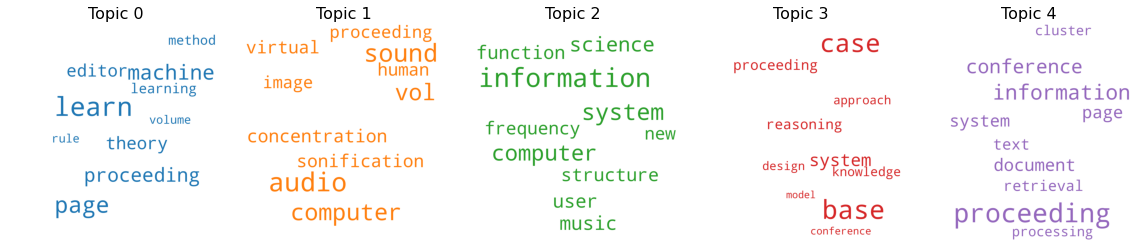

In [8]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=2500,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 5, figsize=(16,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word Counts of Topic Keywords

When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

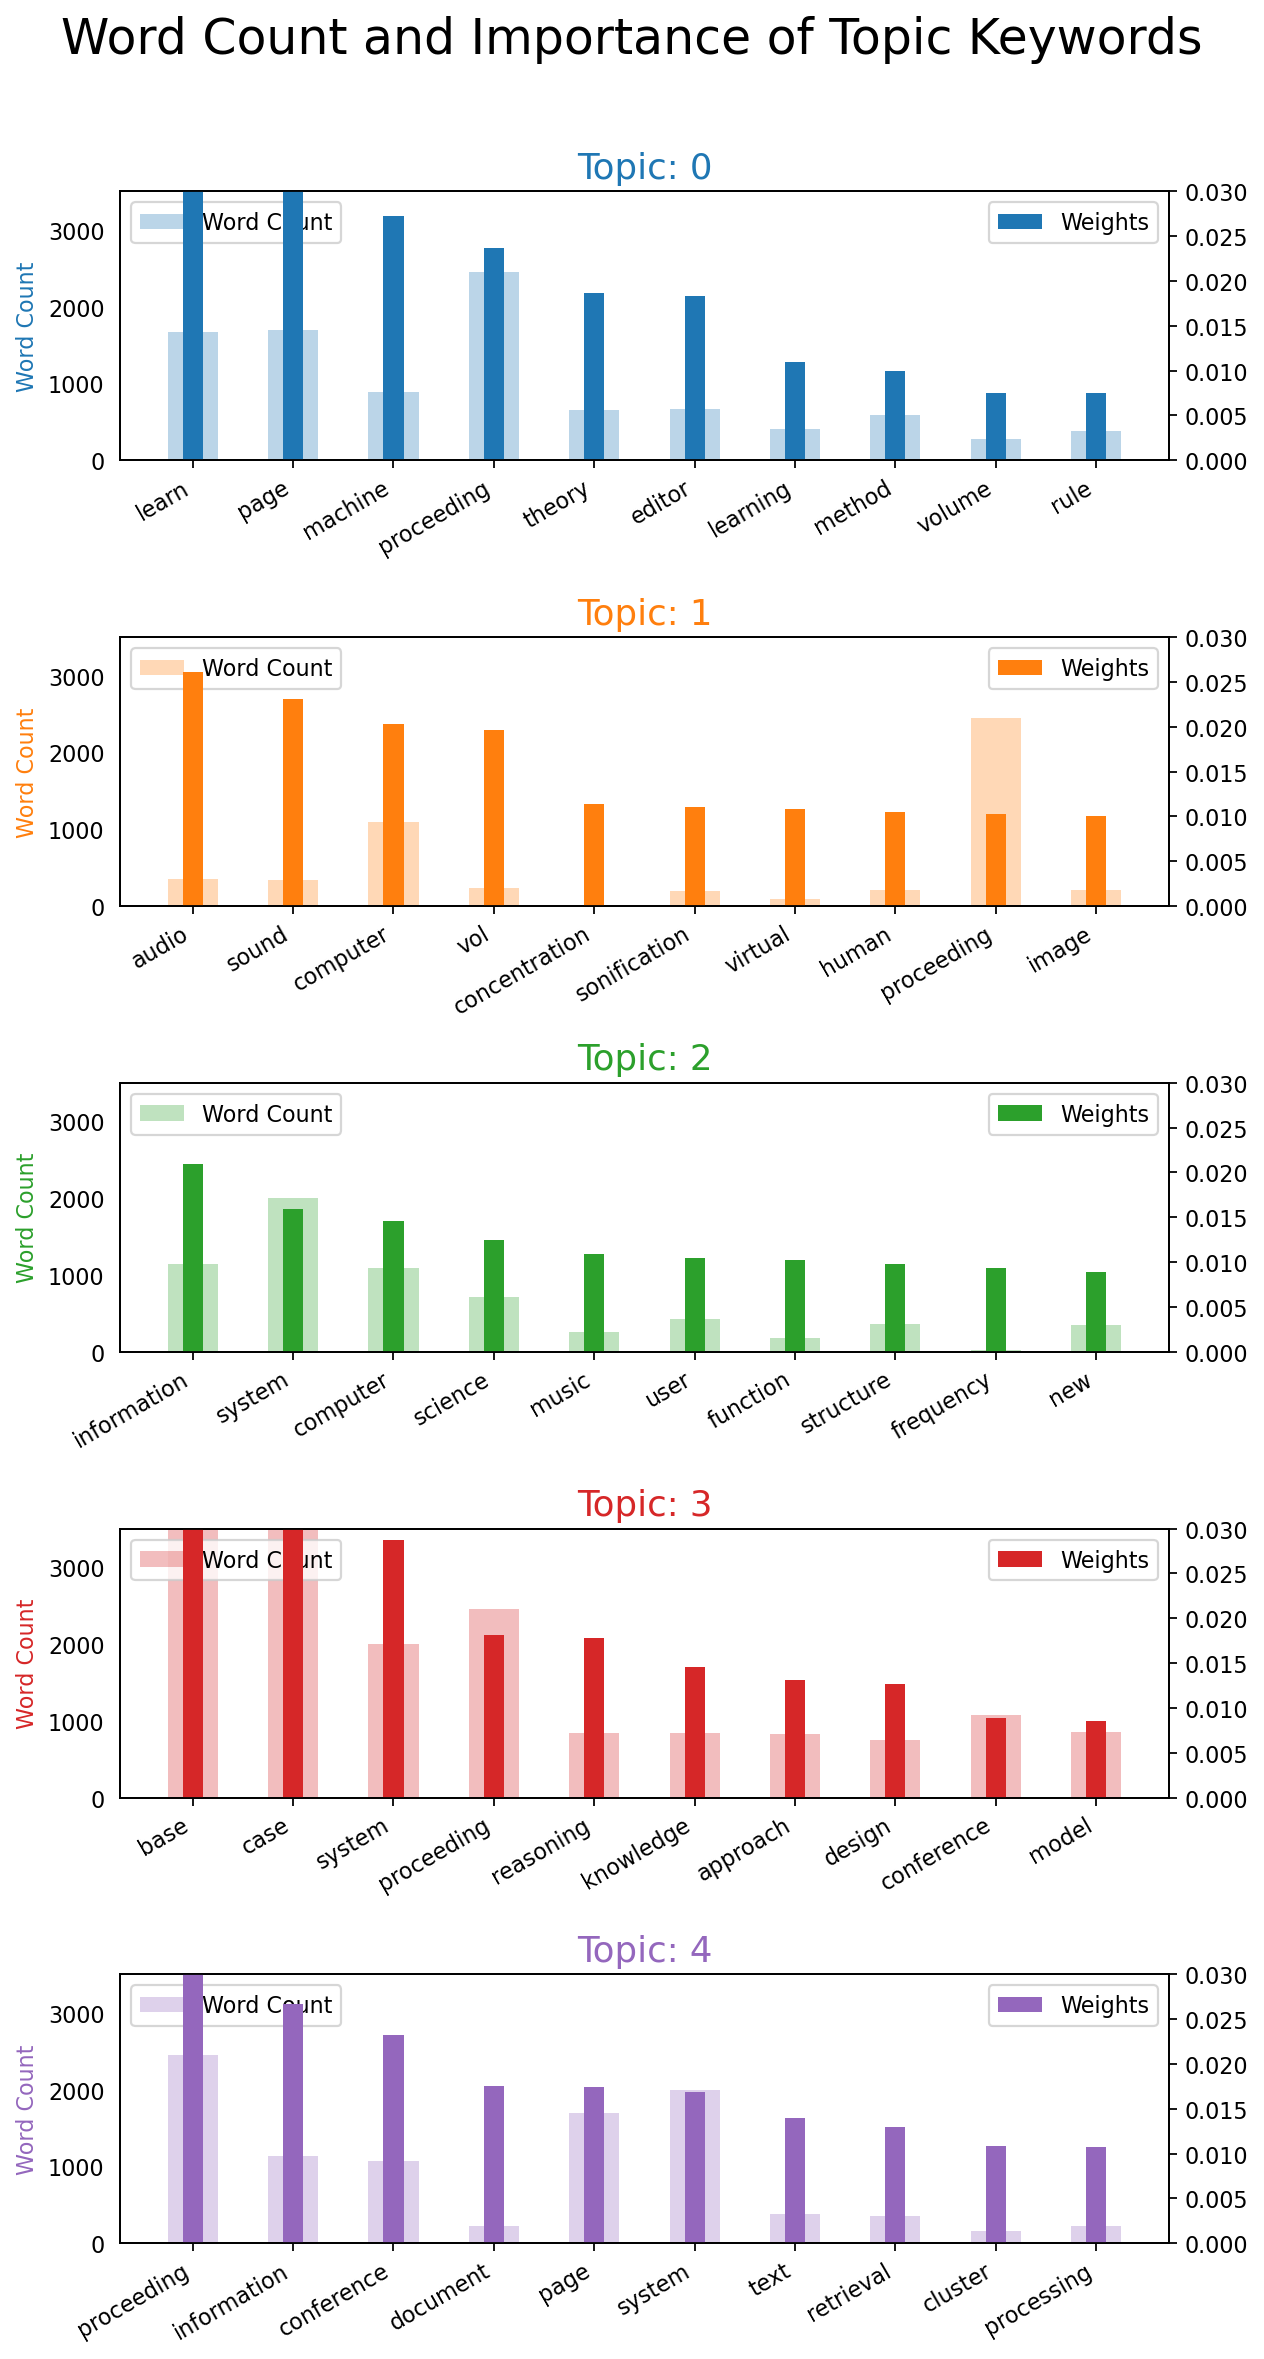

In [9]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 1, figsize=(8,14), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Sentence Chart Colored by Topic

Each word in the document is representative of one of the 4 topics. Let’s color each word in the given documents by the topic id it is attributed to.

The color of the enclosing rectangle is the topic assigned to the document.

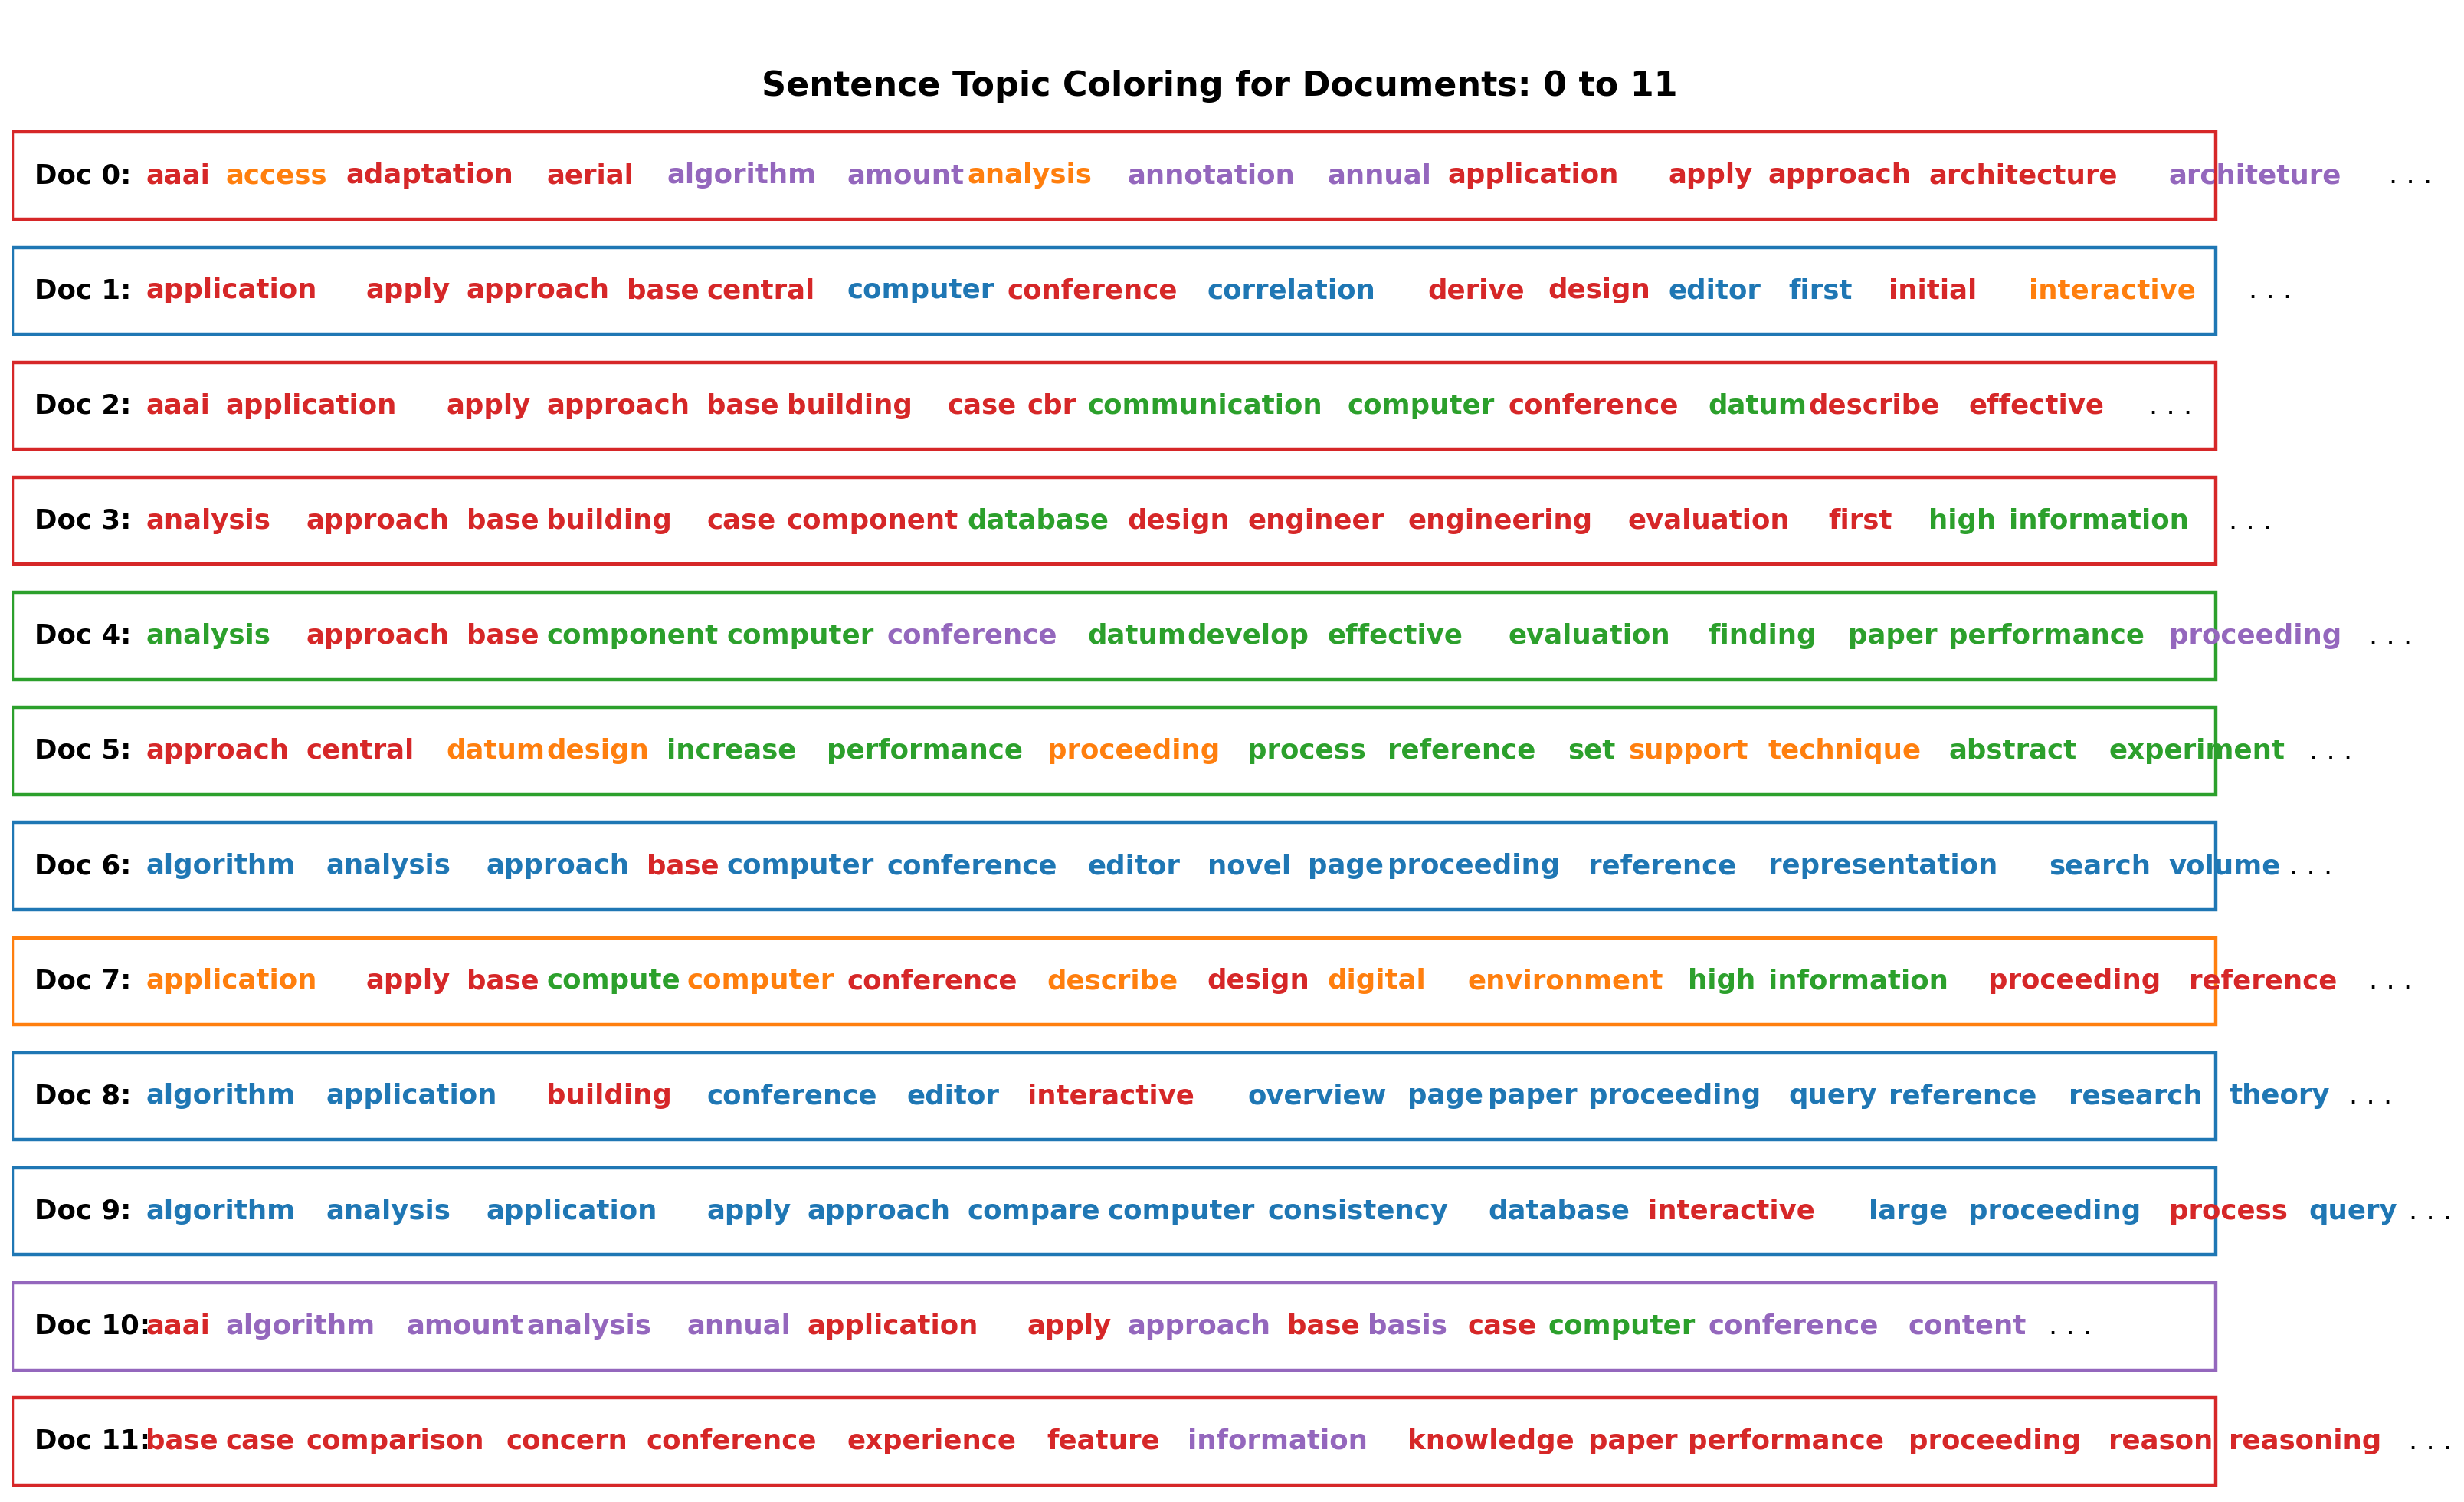

In [10]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))
            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=20, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    


## The most discussed topics in the documents

First, we compute the total number of documents attributed to each topic.

In [11]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Then, we make two plots:

1. The number of documents for each topic by assigning the document to the topic that has the most weight in that document.

2. The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

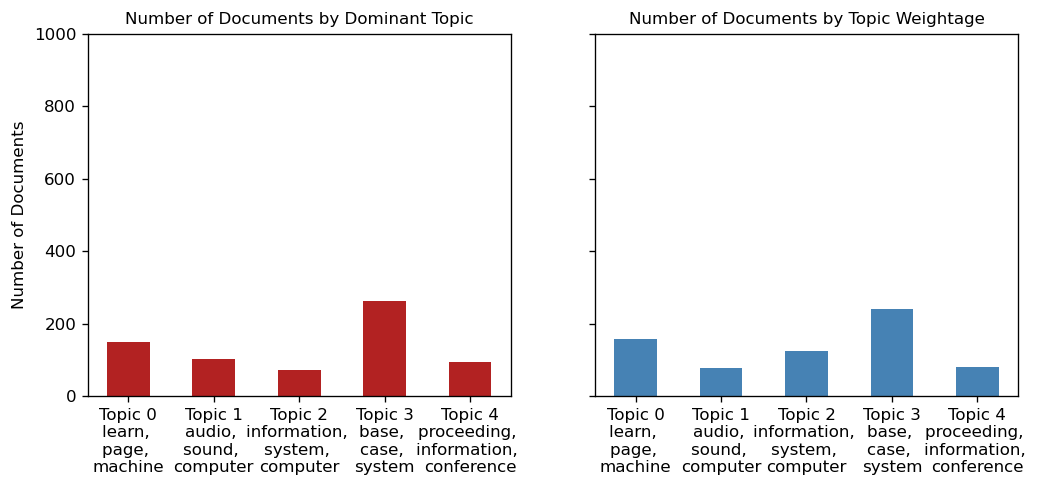

In [12]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

## t-SNE Clustering Chart

Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [13]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
#arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 682 samples in 0.042s...
[t-SNE] Computed neighbors for 682 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 682 / 682
[t-SNE] Mean sigma: 0.078781
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.078056
[t-SNE] KL divergence after 1000 iterations: 0.438563


### Layout 1

(Com as cores do tópico dominante que foi encontrado através da função numpy.argmax() aplicada em um array com os pesos de cada tópico relacionados a cada documento) 

In [14]:
import plotly.express as px

n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

fig = px.scatter(df, x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num], hover_data=[topic_num], labels={'hover_data_0':'topic'})
fig.show()

### Layout 2

(Sem cores para distinguir os pontos e com os tópicos dominantes que foram gerados na função format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready), implementada mais no início deste notebook.)

In [15]:
import plotly.express as px

n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

fig1 = px.scatter(df, x=tsne_lda[:,0], y=tsne_lda[:,1], hover_data=[keywords["Dominant_Topic"]], labels={'hover_data_0':'Dominant Topic'})
fig1.show()

#, color=mycolors[]

### Layout 3

(Com as cores e os dados dos tópicos dominantes que foram gerados na função format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready), implementada mais no início deste notebook.)

In [16]:
array_dominant_topic = np.array(keywords["Dominant_Topic"].values.tolist())

array_dominant_topic = array_dominant_topic.astype(int)

In [17]:
import plotly.express as px

n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

fig1 = px.scatter(df, x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[array_dominant_topic],  hover_data=[keywords["Dominant_Topic"]], labels={'hover_data_0':'Dominant Topic'})
fig1.show()

#

### Layout 4

(Com as cores dos tópicos dominantes que foram gerados na função format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready) e os dados que aparecem são as principais palavras-chaves de cada tópico.)

In [18]:
import plotly.express as px

n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

fig1 = px.scatter(df, x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[array_dominant_topic], hover_data=[keywords["Topic_Keywords"]], labels={'hover_data_0':'topic keywords'})
fig1.show()

## Visualize the information contained in a topic model

PyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model. Below is the implementation for LdaModel().

In [19]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.128650 -0.059926       1        1  35.433308
0      0.162733  0.094898       2        1  21.628050
2     -0.178703 -0.225015       3        1  18.593512
4      0.122887 -0.008862       4        1  12.208426
1     -0.235566  0.198906       5        1  12.136706, topic_info=            Term         Freq        Total Category  logprob  loglift
21          case  3395.000000  3395.000000  Default  30.0000  30.0000
16          base  3770.000000  3770.000000  Default  29.0000  29.0000
232        learn  1431.000000  1431.000000  Default  28.0000  28.0000
138   proceeding  2250.000000  2250.000000  Default  27.0000  27.0000
93   information   884.000000   884.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
96   interactive    71.903076   120.755295   Topic5  -5.3405   1.5905
138   proceeding   153.169601  2250.521484   Topic5  -4.5843  -0.5784
9    application   101.165459   593.760132   Topic5  -4.9991   0.3392
236        model    94.709465   843.102661   Topic5  -5.0650  -0.0773
327         user    79.876312   339.372650   Topic5  -5.2353   0.6623

[306 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1613      3  0.037141   acoust_soc
1613      5  0.947096   acoust_soc
472       5  0.991606     acoustic
332       1  0.994693  acquisition
201       5  0.977443     activity
...     ...       ...          ...
196       2  0.596690     workshop
196       3  0.069957     workshop
196       4  0.049381     workshop
799       2  0.057832         year
799       4  0.944594         year

[433 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 5, 2])

## Conclusion 

We started from scratch by importing, cleaning and processing the dataset to build the LDA model. Then we saw multiple ways to visualize the outputs of topic models including the word clouds and sentence coloring, which intuitively tells you what topic is dominant in each document. A t-SNE clustering and the pyLDAVis are used to provide more details into the clustering of the topics.